In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

### Import all data

In [2]:
# Feather files (Compressed version of the original data to handle with pandas)
train_path = 'data/train_data.ftr'
test_path = 'data/test_data.ftr'

In [4]:
# Label's data or target is already loaded into train_data.ftr
train_data = pd.read_feather(train_path)
test_data = pd.read_feather(test_path)

print("Shape of train data:",train_data.shape)
print("Shape of test data:",test_data.shape)

In [7]:
train_data.info(max_cols=train_data.shape[1] ,show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

In [8]:
train_data.isnull().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_142          4587043
D_143           101548
D_144            40727
D_145           101548
target               0
Length: 191, dtype: int64

In [6]:
train_data1 = train_data.groupby('customer_ID').tail(1).set_index('customer_ID')
test_data1 = test_data.groupby('customer_ID').tail(1).set_index('customer_ID')

del train_data, test_data

# EDA
## Features weights on dataset

In [10]:
def count_features(table: pd.DataFrame) -> dict:
    '''
    This function stores all columns that belong to each feature from the DataFrame.
    '''
    features = {'Delinquency':None, 'Spend':None, 'Payment':None, 'Balance':None, 'Risk':None}

    for k, v in features.items():
        features[k] = len([c for c in table.columns if c.startswith(k[0])])
    
    return features

In [11]:
train_feat = count_features(train_data1)
test_feat = count_features(test_data1)

In [61]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Train amount of features', 'Test amount of features'),
    specs=[[{"type": "pie"}, {"type": "pie"}]]
)

fig.add_trace(go.Pie(
    labels=tuple(train_feat.keys()), values=tuple(train_feat.values()), name='Train'), row=1, col=1
    )

fig.add_trace(go.Pie(
    labels=tuple(test_feat.keys()), values=tuple(test_feat.values()), name='Test'), row=1, col=2
    )

fig.update_layout(
    title_text='Percentage of features'
)

fig.show()

del train_feat, test_feat

Surprisingly whether train or test data share the same distribution of features.

## Missing data

In [55]:
def null_features(table: pd.DataFrame) -> dict:
    '''
    Finds the percentage of missing data per feature of the DataFrame.
    '''
    features = {'Delinquency':None, 'Spend':None, 'Payment':None, 'Balance':None, 'Risk':None}

    for k, v in features.items():
        cols = [c for c in table.columns if c.startswith(k[0])]
        temp_df = table[cols]
        features[k] = round(np.mean(temp_df.isnull().sum()), 2)
    
    return features

In [56]:
train_miss = null_features(train_data1)
test_miss = null_features(test_data1)

In [58]:
fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=('Train/Test null values per feature', ''),
    specs=[[{"type": "bar"}]]
)

fig.add_trace(go.Bar(
    x=tuple(train_miss.keys()), y=tuple(train_miss.values()), name='Train'
))
fig.add_trace(go.Bar(
    x=tuple(test_miss.keys()), y=tuple(test_miss.values()), name='Test'
))

fig.update_layout(
    title_text='Mean presence of null values'
)

fig.show()

del train_miss, test_miss

## Target balance

In [45]:
target = train_data["target"].value_counts()
target_0 = round((target[0]/train_data['target'].count()*100), 2)
target_1 = round((target[1]/train_data['target'].count()*100), 2)

df_target_percentage = pd.DataFrame(data={'Target':['0', '1'], 'Percentage':[target_0, target_1]})

In [46]:
fig = px.bar(df_target_percentage, x='Target', y='Percentage', color='Target', title="Target distribution percentage")
fig.update_layout()
fig.show()

del target, target_0, target_1, df_target_percentage

In [79]:
print(f'Number of unique customers in train: {train_data["customer_ID"].nunique()}')
print(f'Represent the {round((train_data["customer_ID"].nunique()/len(train_data))*100, 2)}% of the train data.')
print()
print(f'Each customer appear in the data around {round(len(train_data)/train_data["customer_ID"].nunique(), 2)} times')

Number of unique customers in train: 458913
Represent the 8.3% of the train data.

Each customer appear in the data around 12.05 times


## Feature correlation

In [105]:
Delinquency = train_data1[[c for c in train_data1.columns if c.startswith('D')] +  ['target']]
Spend       = train_data1[[c for c in train_data1.columns if c.startswith('S')] +  ['target']]
Payment     = train_data1[[c for c in train_data1.columns if c.startswith('P')] +  ['target']]
Balance     = train_data1[[c for c in train_data1.columns if c.startswith('B')] +  ['target']]
Risk        = train_data1[[c for c in train_data1.columns if c.startswith('R')] +  ['target']]

In [76]:
def plot_corr(table: pd.DataFrame, title: str, size: tuple = (12,9), annot: str = False):
    plt.figure(figsize=size)
    sns.heatmap(
        table.corr(),
        annot=annot,
        cmap='coolwarm'
    )
    plt.title(title, fontdict={'fontsize': 18});

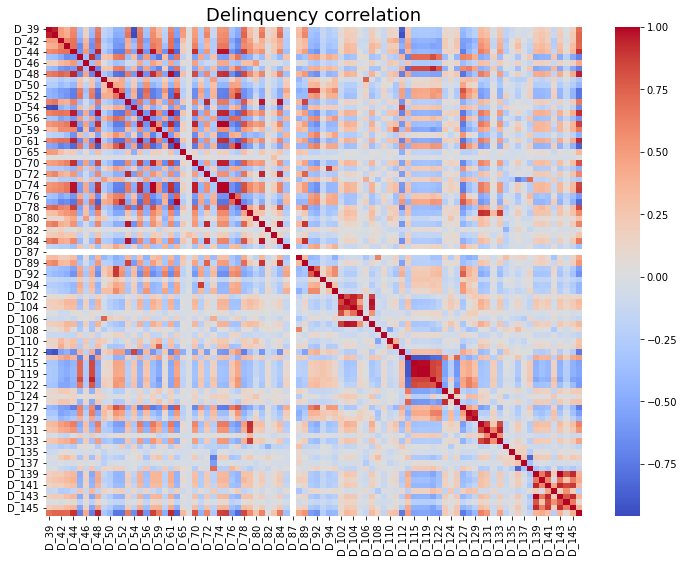

In [77]:
plot_corr(Delinquency.corr(), title='Delinquency correlation')

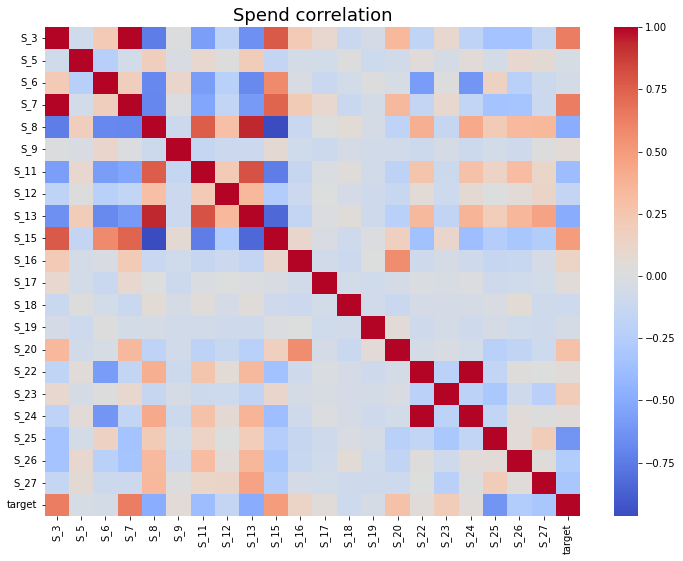

In [78]:
plot_corr(Spend.corr(), title='Spend correlation')

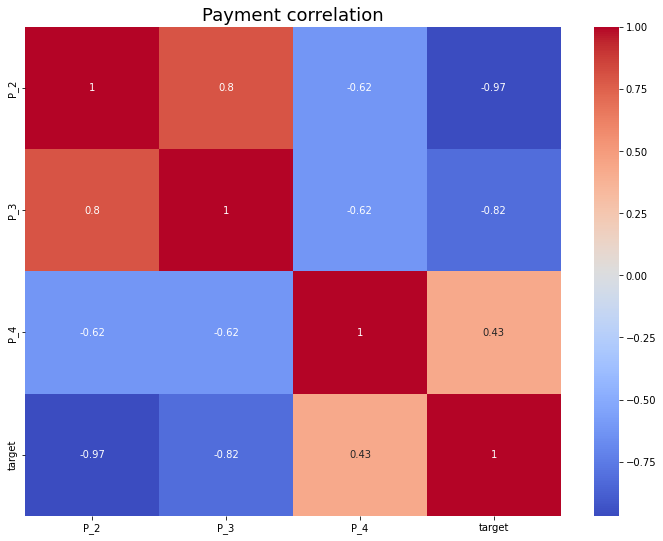

In [79]:
plot_corr(Payment.corr(), title='Payment correlation', annot=True)

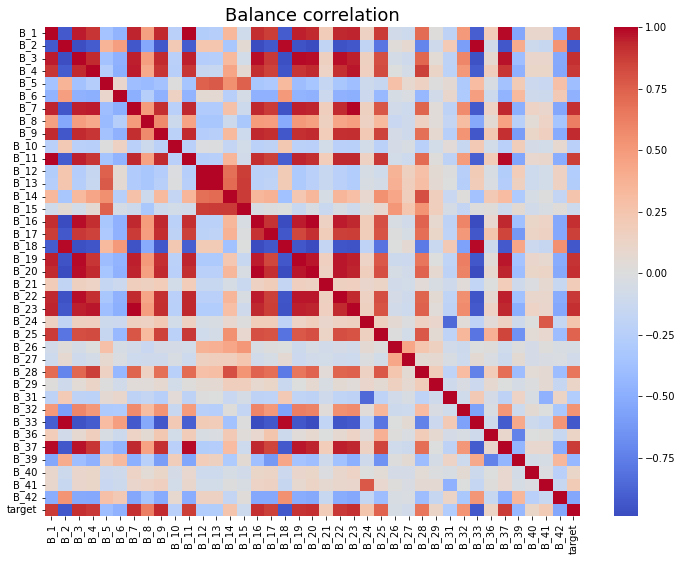

In [80]:
plot_corr(Balance.corr(), title='Balance correlation')

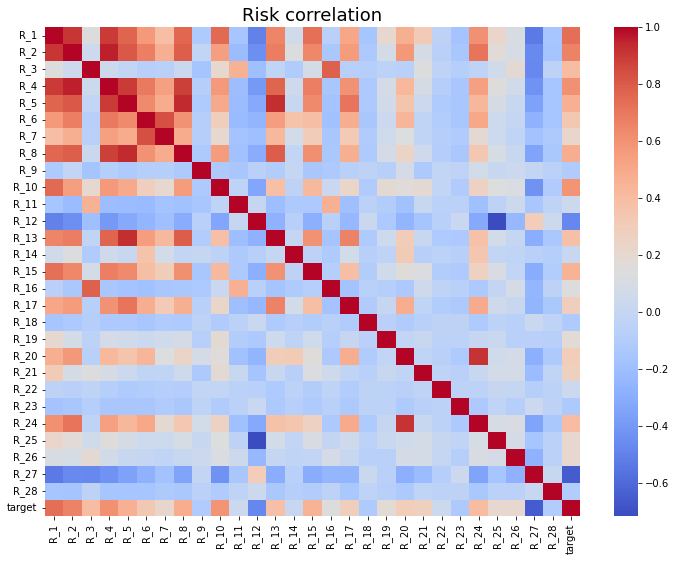

In [81]:
plot_corr(Risk.corr(), title='Risk correlation')

In [ ]:
del Delinquency, Spend, Payment, Balance, Risk

In [83]:
target = train_data1.corrwith(train_data1['target'], axis=0)
val = [str(round(v ,1) *100) + '%' for v in target.values]

fig = go.Figure()
fig.add_trace(go.Bar(y=target.index, x=target.values, orientation='h', text = val))
fig.update_layout(title = "Correlation of variables with Target", width = 700, height = 3000)
fig.show()

del target, val

# Export datasets

In [7]:
train_data1.to_csv('data/train_data.csv')
test_data1.to_csv('data/test_data.csv')